In [0]:
import pandas as pd

In [0]:
!mkdir planes

In [4]:
!unzip "/content/drive/My Drive/cgi-planes-in-satellite-imagery-w-bboxes.zip" -d planes

Archive:  /content/drive/My Drive/cgi-planes-in-satellite-imagery-w-bboxes.zip
  inflating: planes/test/img401.png  
  inflating: planes/test/img401.xml  
  inflating: planes/test/img402.png  
  inflating: planes/test/img402.xml  
  inflating: planes/test/img403.png  
  inflating: planes/test/img403.xml  
  inflating: planes/test/img404.png  
  inflating: planes/test/img404.xml  
  inflating: planes/test/img405.png  
  inflating: planes/test/img405.xml  
  inflating: planes/test/img406.png  
  inflating: planes/test/img406.xml  
  inflating: planes/test/img407.png  
  inflating: planes/test/img407.xml  
  inflating: planes/test/img408.png  
  inflating: planes/test/img408.xml  
  inflating: planes/test/img409.png  
  inflating: planes/test/img409.xml  
  inflating: planes/test/img410.png  
  inflating: planes/test/img410.xml  
  inflating: planes/test/img411.png  
  inflating: planes/test/img411.xml  
  inflating: planes/test/img412.png  
  inflating: planes/test/img412.xml  
  inflati

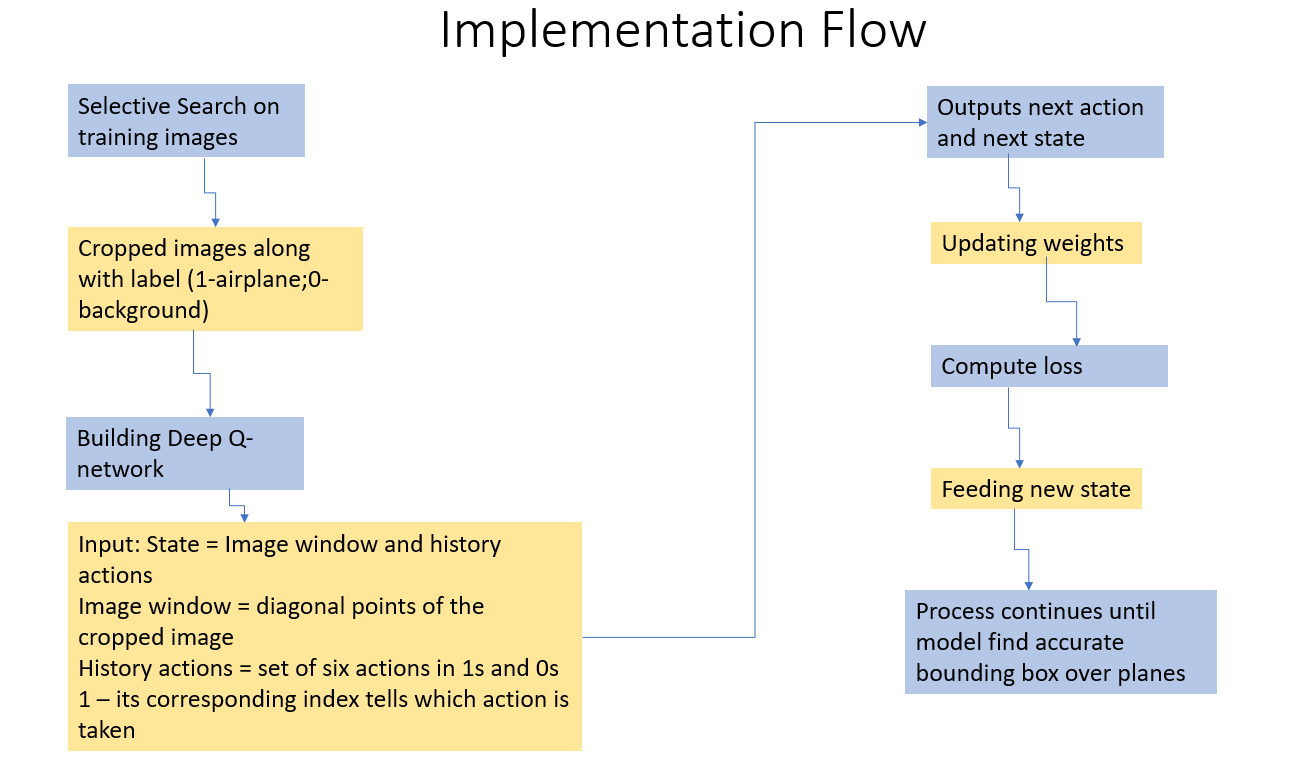

Brief description of our work
- With training images, selective search algorithm is applied which gives cropped image as output from the given image along with a label mentioning whether it is a plane or background
- The algorithm approximately gives the correct labeling
- With the labels that are planes alone are considered for next step, as this reduces time
- Also, the boubding box points of each plane image is also taken and stored
- With all these, training is started
- Take an image, its corresponding bounding box points, which are considered as ground truth box and history actions, which are created randomly, state is defined
- Epsilon-greedy is used for exploration and exploitation
- Based on the history actions, we predict the next action
- We use a shrink rate which tells, from the current state how many steps model has to take, to go to the new state
- New state is updated, history actions are also updated by removing the first history action and appending the new action
- This process continues until the episode ends

In [0]:
train = pd.read_csv("/content/planes/train_labels.csv")

In [6]:
!pip install opencv-contrib-python

In [0]:
import cv2

In [0]:
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [0]:
Unique_filename = train['filename'].unique()
group_by_filename = train.groupby(['filename'])

In [0]:
def get_iou(bb1, bb2):
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [11]:
len(Unique_filename)

400

In [0]:
bounding_box = []
train_images=[]
train_labels=[]

for file in range(100):
    path = "/content/planes/train/" + Unique_filename[file] 
    temp = group_by_filename.get_group(Unique_filename[file])
    gtvalues=[]
    image = cv2.imread(path)
    for row in range(temp.shape[0]):
        x1 = train['xmin'][row]
        y1 = train['ymin'][row]
        x2 = train['xmax'][row]
        y2 = train['ymax'][row]
        gtvalues.append({"x1":x1,"x2":x2,"y1":y1,"y2":y2})
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    ssresults = ss.process()
    imout = image.copy()
    counter = 0
    falsecounter = 0
    flag = 0
    fflag = 0
    bflag = 0
    for e,result in enumerate(ssresults):
        if e < 2000 and flag == 0:
            for gtval in gtvalues:
                x,y,w,h = result
                iou = get_iou(gtval,{"x1":x,"x2":x+w,"y1":y,"y2":y+h})
                if counter < 30:
                    if iou > 0.70:
                        temp = []
                        temp.append(y)
                        temp.append(y+h)
                        temp.append(x)
                        temp.append(x+w)
                        timage = imout[y:y+h,x:x+w]
                        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                        bounding_box.append(temp)
                        train_images.append(resized)
                        train_labels.append(1)
                        counter += 1
                else :
                    fflag =1
                if falsecounter <30:
                    if iou < 0.3:
                        temp = []
                        temp.append(y)
                        temp.append(y+h)
                        temp.append(x)
                        temp.append(x+w)
                        timage = imout[y:y+h,x:x+w]
                        resized = cv2.resize(timage, (224,224), interpolation = cv2.INTER_AREA)
                        train_images.append(resized)
                        bounding_box.append(temp)
                        train_labels.append(0)
                        falsecounter += 1
                else :
                    bflag = 1
            if fflag == 1 and bflag == 1:
                print("inside")
                flag = 1

In [13]:
len(train_images)

3006

In [0]:
import numpy as np

In [0]:
import matplotlib.pyplot as plt
from google.colab import files

In [0]:
plane_index = []
for i in range(len(train_labels)):
  if train_labels[i] == 1:
    plane_index.append(i)

In [17]:
len(plane_index)

11

Building Q-learning model

In [0]:
# Inputs to build the model
tou = 0.5 #used for reward updation
eta = 3.0
epsilon = 1.0
shrink_rate = 0.75
no_of_epochs = 50
threshold = 0.5
alpha = 0.3
discount_factor = 0.3

action_desc = ['top-left','top-right','bottom-left','bottom-right','middle','End']
actions = list(range(6))

# Creating Q-network matrix
x = [0.0]*len(actions)
Q_table = [x]*len(actions)

Q_table = pd.DataFrame(Q_table)

In [0]:
import random

In [24]:
Episodes = []
final_BB = []

for epoch in range(50):
  if epsilon >= 0.1:
      epsilon = epsilon - 0.1
      BB = []
  for image in plane_index:
      image_window = []
      gt_window = []
      history_actions = []
      State = []
      # Initailising image window

      image_window.append({"x1":150,"x2":50,"y1":125,"y2":75})
      gt_window.append({"x1":bounding_box[image][2],"x2":bounding_box[image][3],"y1":bounding_box[image][0],"y2":bounding_box[image][1]})
      
      # Initialising history actions
      history_actions.append([0,1,0,0,0,0])
      history_actions.append([1,0,0,0,0,0])
      history_actions.append([0,0,0,0,1,0])
      history_actions.append([0,0,0,0,0,1])
      history_actions.append([0,0,0,0,0,1])
      history_actions.append([0,0,0,0,0,1])
      
      # Constructing state with w and h
      State.append(image_window)
      State.append(history_actions)
      s = random.choices(actions)

      # terminating variable
      f = False
      cum_reward = 0
      while(f == False):
          Reward = 0
          if epsilon < threshold:
              action = random.choices(actions)[0]
          else:
              IOU = []
              action_set = []
              for i in range(len(history_actions)):
                  pred_values = []
                  temp = history_actions[i]
                  index = temp.index(1)
                  if index == 0:
                      new_y1 = State[0][0]['y1'] - 10
                      new_y2 = State[0][0]['y2'] - 10
                      new_x1 = State[0][0]['x1'] - 10
                      new_x2 = State[0][0]['x2'] - 10
                      pred_values.append({"x1":new_x1,"x2":new_x2,"y1":new_y1,"y2":new_y2})
                      IOU.append(get_iou(pred_values[0],gt_window[0]))
                      action_set.append(index)

                  if index == 1:
                      new_y1 = State[0][0]['y1'] + 10
                      new_y2 = State[0][0]['y2'] + 10
                      new_x1 = State[0][0]['x1'] - 10
                      new_x2 = State[0][0]['x2'] - 10
                      pred_values.append({"x1":new_x1,"x2":new_x2,"y1":new_y1,"y2":new_y2})
                      IOU.append(get_iou(pred_values[0],gt_window[0]))
                      action_set.append(index)

                  if index == 2:
                      new_y1 = State[0][0]['y1'] - 10
                      new_y2 = State[0][0]['y2'] - 10
                      new_x1 = State[0][0]['x1'] + 10
                      new_x2 = State[0][0]['x2'] + 10
                      pred_values.append({"x1":new_x1,"x2":new_x2,"y1":new_y1,"y2":new_y2})
                      IOU.append(get_iou(pred_values[0],gt_window[0]))
                      action_set.append(index)

                  if index == 3:
                      new_y1 = State[0][0]['y1'] + 10
                      new_y2 = State[0][0]['y2'] + 10
                      new_x1 = State[0][0]['x1'] + 10
                      new_x2 = State[0][0]['x2'] + 10
                      pred_values.append({"x1":new_x1,"x2":new_x2,"y1":new_y1,"y2":new_y2})
                      IOU.append(get_iou(pred_values[0],gt_window[0]))
                      action_set.append(index)

                  if index == 4:
                      new_y1 = State[0][0]['y1'] + 10
                      new_y2 = State[0][0]['y2'] - 10
                      new_x1 = State[0][0]['x1'] + 10
                      new_x2 = State[0][0]['x2'] - 10
                      pred_values.append({"x1":new_x1,"x2":new_x2,"y1":new_y1,"y2":new_y2})
                      IOU.append(get_iou(pred_values[0],gt_window[0]))
                      action_set.append(index)

                  if index == 5:
                      IOU.append(get_iou(image_window[0],gt_window[0]))
                      action_set.append(index)

              argmax_iou = IOU.index(max(IOU))
              action = action_set[argmax_iou]

          if action == 0:
              new_y1 = State[0][0]['y1'] - 10
              new_y2 = State[0][0]['y2'] - 10
              new_x1 = State[0][0]['x1'] - 10
              new_x2 = State[0][0]['x2'] - 10
              image_window[0]['x1'] = new_x1
              image_window[0]['x2'] = new_x2
              image_window[0]['y1'] = new_y1
              image_window[0]['y2'] = new_y2

          if action == 1:
              new_y1 = State[0][0]['y1'] + 10
              new_y2 = State[0][0]['y2'] + 10
              new_x1 = State[0][0]['x1'] - 10
              new_x2 = State[0][0]['x2'] - 10
              image_window[0]['x1'] = new_x1
              image_window[0]['x2'] = new_x2
              image_window[0]['y1'] = new_y1
              image_window[0]['y2'] = new_y2

          if action == 2:
              new_y1 = State[0][0]['y1'] - 10
              new_y2 = State[0][0]['y2'] - 10
              new_x1 = State[0][0]['x1'] + 10
              new_x2 = State[0][0]['x2'] + 10
              image_window[0]['x1'] = new_x1
              image_window[0]['x2'] = new_x2
              image_window[0]['y1'] = new_y1
              image_window[0]['y2'] = new_y2

          if action == 3:
              new_y1 = State[0][0]['y1'] + 10
              new_y2 = State[0][0]['y2'] + 10
              new_x1 = State[0][0]['x1'] + 10
              new_x2 = State[0][0]['x2'] + 10
              image_window[0]['x1'] = new_x1
              image_window[0]['x2'] = new_x2
              image_window[0]['y1'] = new_y1
              image_window[0]['y2'] = new_y2

          if action == 4:
              new_y1 = State[0][0]['y1'] + 10
              new_y2 = State[0][0]['y2'] - 10
              new_x1 = State[0][0]['x1'] + 10
              new_x2 = State[0][0]['x2'] - 10
              image_window[0]['x1'] = new_x1
              image_window[0]['x2'] = new_x2
              image_window[0]['y1'] = new_y1
              image_window[0]['y2'] = new_y2
          
          argmax_iou = get_iou(image_window[0],gt_window[0])
          dup_State = State
          history_actions.pop(0)
          t = []
          for i in range(6):
            if i != action:
              t.append(0)
            else:
              t.append(1)
          history_actions.append(t)
          State = []
          State.append(image_window)
          State.append(history_actions)

          # Finding a-dash given s-dash
          IOU = []
          action_set = []
          for i in range(len(history_actions)):
              pred_values = []
              temp = history_actions[i]
              index = temp.index(1)
              if index == 0:
                  new_y1 = State[0][0]['y1'] - 10
                  new_y2 = State[0][0]['y2'] - 10
                  new_x1 = State[0][0]['x1'] - 10
                  new_x2 = State[0][0]['x2'] - 10
                  pred_values.append({"x1":new_x1,"x2":new_x2,"y1":new_y1,"y2":new_y2})
                  IOU.append(get_iou(pred_values[0],gt_window[0]))
                  action_set.append(index)

              if index == 1:
                  new_y1 = State[0][0]['y1'] + 10
                  new_y2 = State[0][0]['y2'] + 10
                  new_x1 = State[0][0]['x1'] - 10
                  new_x2 = State[0][0]['x2'] - 10
                  pred_values.append({"x1":new_x1,"x2":new_x2,"y1":new_y1,"y2":new_y2})
                  IOU.append(get_iou(pred_values[0],gt_window[0]))
                  action_set.append(index)

              if index == 2:
                  new_y1 = State[0][0]['y1'] - 10
                  new_y2 = State[0][0]['y2'] - 10
                  new_x1 = State[0][0]['x1'] + 10
                  new_x2 = State[0][0]['x2'] + 10
                  pred_values.append({"x1":new_x1,"x2":new_x2,"y1":new_y1,"y2":new_y2})
                  IOU.append(get_iou(pred_values[0],gt_window[0]))
                  action_set.append(index)

              if index == 3:
                  new_y1 = State[0][0]['y1'] + 10
                  new_y2 = State[0][0]['y2'] + 10
                  new_x1 = State[0][0]['x1'] + 10
                  new_x2 = State[0][0]['x2'] + 10
                  pred_values.append({"x1":new_x1,"x2":new_x2,"y1":new_y1,"y2":new_y2})
                  IOU.append(get_iou(pred_values[0],gt_window[0]))
                  action_set.append(index)

              if index == 4:
                  new_y1 = State[0][0]['y1'] + 10
                  new_y2 = State[0][0]['y2'] - 10
                  new_x1 = State[0][0]['x1'] + 10
                  new_x2 = State[0][0]['x2'] - 10
                  pred_values.append({"x1":new_x1,"x2":new_x2,"y1":new_y1,"y2":new_y2})
                  IOU.append(get_iou(pred_values[0],gt_window[0]))
                  action_set.append(index)

              if index == 5:
                  IOU.append(get_iou(image_window[0],gt_window[0]))
                  action_set.append(index)


          iou_dash = IOU.index(max(IOU))
          action_dash = action_set[iou_dash]

          # Reward updation
          if action == 5:
              f = True
              if argmax_iou >= tou:
                Reward = eta
              else:
                Reward = -eta
          else:
            f = False
            Reward = get_iou(image_window[0],gt_window[0]) - get_iou(State[0][0],gt_window[0]) 
          
          Episodes.append({"current_state":dup_State,"Action":action_desc[action],"Reward":Reward,"next_state":State})

          cum_reward = cum_reward + Reward
          current_state = s
          s = action
          print("action =", action, end='\r', flush=False)
          # Updating Q_table
          Q_table.iloc[current_state,action] = Q_table.iloc[current_state,action] + (alpha*(Reward + (discount_factor*max(Q_table.iloc[:,action_dash]) - Q_table.iloc[current_state,action])))
      BB.append({"image":image, "Bounding_box":State[0]})
  print("Epoch =",epoch,"Total Reward =",cum_reward)
  final_BB.append({"epoch":epoch, "BB":BB})

Epoch = 0 Total Reward = -3.0
Epoch = 1 Total Reward = -3.0
Epoch = 2 Total Reward = -3.0
Epoch = 3 Total Reward = -3.0
Epoch = 4 Total Reward = -3.0
Epoch = 5 Total Reward = -3.0
Epoch = 6 Total Reward = -3.0
Epoch = 7 Total Reward = -3.0
Epoch = 8 Total Reward = -3.0
Epoch = 9 Total Reward = -3.0
Epoch = 10 Total Reward = -3.0
Epoch = 11 Total Reward = -3.0
Epoch = 12 Total Reward = -3.0
Epoch = 13 Total Reward = -3.0
Epoch = 14 Total Reward = -3.0
Epoch = 15 Total Reward = -3.0
Epoch = 16 Total Reward = -3.0
Epoch = 17 Total Reward = -3.0
Epoch = 18 Total Reward = -3.0
Epoch = 19 Total Reward = -3.0
Epoch = 20 Total Reward = -3.0
Epoch = 21 Total Reward = -3.0
Epoch = 22 Total Reward = -3.0
Epoch = 23 Total Reward = -3.0
Epoch = 24 Total Reward = -3.0
Epoch = 25 Total Reward = -3.0
Epoch = 26 Total Reward = -3.0
Epoch = 27 Total Reward = -3.0
Epoch = 28 Total Reward = -3.0
Epoch = 29 Total Reward = -3.0
Epoch = 30 Total Reward = -3.0
Epoch = 31 Total Reward = -3.0
Epoch = 32 Total R

In [25]:
Q_table

,0,1,2,3,4,5
0,-0.140883,-0.039991,-0.692978,-0.560967,-0.588549,-3.030346
1,-0.476359,-0.020839,-0.129417,-0.261690,-0.035937,-3.275453
2,-0.528797,-0.404064,-0.321961,-0.147200,-0.447441,-3.206037
3,-0.605401,-0.200080,-0.686186,-0.072562,-0.061441,-3.415621
4,-0.149312,-0.288180,-0.141037,-0.650141,-0.177628,-3.521253
5,0.000000,0.000000,0.000000,0.000000,0.000000,-2.999598


In [26]:
final_BB[2]

{'BB': [{'Bounding_box': [{'x1': 150, 'x2': 50, 'y1': 125, 'y2': 75}],
   'image': 420},
  {'Bounding_box': [{'x1': 180, 'x2': 0, 'y1': 175, 'y2': 45}], 'image': 571},
  {'Bounding_box': [{'x1': 160, 'x2': 40, 'y1': 135, 'y2': 65}], 'image': 632},
  {'Bounding_box': [{'x1': 140, 'x2': 40, 'y1': 115, 'y2': 65}],
   'image': 1023},
  {'Bounding_box': [{'x1': 160, 'x2': 40, 'y1': 155, 'y2': 85}],
   'image': 1264},
  {'Bounding_box': [{'x1': 140, 'x2': 20, 'y1': 135, 'y2': 65}],
   'image': 1265},
  {'Bounding_box': [{'x1': 150, 'x2': 50, 'y1': 125, 'y2': 75}],
   'image': 2016},
  {'Bounding_box': [{'x1': 140, 'x2': 0, 'y1': 155, 'y2': 65}], 'image': 2287},
  {'Bounding_box': [{'x1': 190, 'x2': 10, 'y1': 185, 'y2': 55}],
   'image': 2468},
  {'Bounding_box': [{'x1': 150, 'x2': 50, 'y1': 125, 'y2': 75}],
   'image': 2679},
  {'Bounding_box': [{'x1': 150, 'x2': 50, 'y1': 125, 'y2': 75}],
   'image': 2710},
  {'Bounding_box': [{'x1': 160, 'x2': 40, 'y1': 135, 'y2': 65}], 'image': 420},
  {'

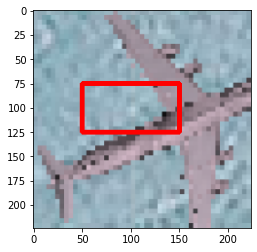

In [27]:
im = train_images[420].copy()
cv2.rectangle(im, (150,125), (50,75), (255,0,0), 4)
plt.imshow(im)

In [0]:
for i in plane_index:
  plt.imshow(train_images[i])
  plt.axis('off')
  name = "plane" + str(i) + ".png"
  plt.savefig(name)
  files.download(name)